## Instructions

Here's the [link](https://colab.research.google.com/drive/1SPgVGGIvzaKt8qs7EJKcr_SZbbWnuQLm?usp=sharing) to the Colab-Notebook

Follow this [Video](https://www.youtube.com/watch?v=n9_XyCGr-MI) for code explainations and formats

These are some [instructions](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) on how to work with Kaggle API and Google-Colab

For Architechture Details : [Link-1](http://media5.datahacker.rs/2019/05/yolo_arch-1024x411.png) [Link-2](https://lilianweng.github.io/lil-log/assets/images/yolo-network-architecture.png)

For Loss Details : [Link-1](https://cdn-images-1.medium.com/max/480/1*YlYjgdGShsAYE-GYDHCjYQ.png) [Link-2](https://miro.medium.com/max/1276/0*asmbNz2iVZ6hmuHu.jpg)

[Yolo Paper](https://arxiv.org/pdf/1506.02640.pdf)


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [7]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle


/content/gdrive/My Drive/Kaggle


In [26]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.30G/4.31G [01:29<00:00, 50.4MB/s]
100% 4.31G/4.31G [01:29<00:00, 51.6MB/s]


In [27]:
!unzip \*.zip 

Streaming output truncated to the last 5000 lines.
  inflating: labels/2009_004289.txt  
  inflating: labels/2009_004290.txt  
  inflating: labels/2009_004291.txt  
  inflating: labels/2009_004295.txt  
  inflating: labels/2009_004298.txt  
  inflating: labels/2009_004300.txt  
  inflating: labels/2009_004301.txt  
  inflating: labels/2009_004303.txt  
  inflating: labels/2009_004307.txt  
  inflating: labels/2009_004308.txt  
  inflating: labels/2009_004309.txt  
  inflating: labels/2009_004312.txt  
  inflating: labels/2009_004315.txt  
  inflating: labels/2009_004316.txt  
  inflating: labels/2009_004317.txt  
  inflating: labels/2009_004319.txt  
  inflating: labels/2009_004322.txt  
  inflating: labels/2009_004323.txt  
  inflating: labels/2009_004324.txt  
  inflating: labels/2009_004327.txt  
  inflating: labels/2009_004328.txt  
  inflating: labels/2009_004329.txt  
  inflating: labels/2009_004332.txt  
  inflating: labels/2009_004334.txt  
  inflating: labels/2009_004336.txt  

In [28]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as ft
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
seed = 123
torch.manual_seed(seed);

In [85]:
architecture = [
#     tuple -> (kernel_size,filters,stride,padding)
#     M -> Max-Pooling 
    (7,64,2,3),
    'M',
    (3,192,1,1),
    'M',
    (1,128,1,0),
    (3,256,1,1),
    (1,256,1,0),
    (3,512,1,1),
    'M',
    [(1,256,1,0),(3,512,1,1),4],
    (1,512,1,0),
    (3,1024,1,1),
    'M',
    [(1,512,1,0),(3,1024,1,1),2],
    (3,1024,1,1),
    (3,1024,2,1),
    (3,1024,1,1),
    (3,1024,1,1),
]

In [30]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,**kwargs):
        super(CNN_Block,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,bias=False,**kwargs)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
    
    def forward(self,X):
        return self.leaky_relu(self.batch_norm(self.conv(X)))


In [31]:
class Yolo(nn.Module):
    def __init__(self,in_channels=3,**args):
        super(Yolo,self).__init__()
        self.architecture = architecture
        self.in_channels = in_channels
        self.dark_net = self.create_conv_layers(self.architecture)
        self.fully_connected = self.create_fully_connected(**args)

    def forward(self,X):
        X = self.dark_net(X)
        return self.fully_connected(torch.flatten(X,start_dim=1))

    def create_conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        for i in architecture:
            if type(i) == tuple:
                layers.append(CNN_Block(in_channels=in_channels,out_channels=i[1],kernel_size=i[0],
                                        stride=i[2],padding=i[3]))
                in_channels = i[1]
            elif type(i) == str:
                layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
            elif type(i) == list:
                conv_1 = i[0] #first layer
                conv_2 = i[1] #second layer
                repeats = i[2]
                for j in range(repeats):
                    layers.append((CNN_Block(in_channels=in_channels,out_channels=conv_1[1],
                                             kernel_size=conv_1[0],stride=conv_1[2],padding=conv_1[3])))
                    layers.append((CNN_Block(in_channels=conv_1[1],out_channels=conv_2[1],
                                             kernel_size=conv_2[0],stride=conv_2[2],padding=conv_2[3])))

                in_channels = conv_2[1]
            
        return nn.Sequential(*layers)

    def create_fully_connected(self,size, num_boxes, num_classes):
        layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*size*size,4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, size * size * (num_classes + num_boxes * 5)),
        )
        return layers


In [32]:
class Loss(nn.Module):
    def __init__(self,size=7,boxes=2,classes=20):
        super(Loss,self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.size = size
        self.boxes = boxes
        self.classes = classes
        self.lambda_no_obj = 0.5
        self.lambda_coord = 5
    
    def forward(self,prediction,target):
        prediction = prediction.reshape(-1,self.size,self.size,self.classes+(self.boxes)*5)
        iou_box1 = intersection_over_union(prediction[...,21:25],target[...,21:25])
        iou_box2 = intersection_over_union(prediction[...,26:30],target[...,21:25])
        ious = torch.cat([iou_box1.unsqueeze(0),iou_box2.unsqueeze(0)],dim=0)
        iou_maxes, best_box = torch.max(ious,dim=0)
        exists_box = target[...,20].unsqueeze(3)
        
#         for box coord
        box_predictions = exists_box * ((best_box*prediction[...,26:30]+
                                        (1-best_box)*prediction[...,21:25]))
        box_targets = exists_box*target[...,21:25]
        box_predictions[...,2:4] = (torch.sign(box_predictions[...,2:4]) * 
                                    torch.sqrt(torch.abs(box_predictions[...,2:4]) + 1e-6))
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4])
        box_loss = self.mse(
            torch.flatten(box_predictions,end_dim=-2),
            torch.flatten(box_targets,end_dim=-2)
        )
        
#       object loss
        pred_box = (best_box*prediction[...,25:26]+(1-best_box)*prediction[...,20:21])
        object_loss = self.mse(
            torch.flatten(exists_box*pred_box),
            torch.flatten(exists_box*target[...,20:21])
        )
        
#       no object loss  
        no_obj_loss = self.mse(
            torch.flatten((1-exists_box)*prediction[...,20:21],start_dim=1),
            torch.flatten((1-exists_box)*target[...,20:21],start_dim=1)
        )
        
        no_obj_loss += self.mse(
            torch.flatten((1-exists_box)*prediction[...,25:26],start_dim=1),
            torch.flatten((1-exists_box)*target[...,20:21],start_dim=1)
        )
        
#         class loss
        class_loss = self.mse(
            torch.flatten(exists_box*prediction[...,:20],end_dim=-1),
            torch.flatten(exists_box*target[...,:20],end_dim=-2)
        )
    
        loss = (
            self.lambda_coord*box_loss
            + object_loss
            + self.lambda_no_obj*no_obj_loss
            + class_loss
        )
        
        return loss

    

In [81]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file,img_file,label_file,size=7,boxes=2,classes=20,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_file = img_file
        self.label_file = label_file
        self.size = size
        self.boxes = boxes
        self.classes = classes
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        # label_path = os.path.join(self.label_file,self.annotations.iloc[index,1])
        label_path = "/content/gdrive/MyDrive/Kaggle/"+self.label_file +'/'+ self.annotations.iloc[index,1]
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label,x,y,w,h = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n","").split()
                ]
                boxes.append([class_label,x,y,w,h])
        
        # img_path = os.path.join(self,img_file,self.annotations.iloc[index,0])
        img_path = "/content/gdrive/MyDrive/Kaggle/" + self.img_file + '/'+self.annotations.iloc[index,0]
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        if self.transform:
            image,boxes = self.transform(image,boxes)
        
        label_matrix = torch.zeros((self.size,self.size,self.classes+5*self.boxes))
        for box in boxes:
            class_label,x,y,w,h = box.tolist()
            class_label = int(class_label)
            i,j = int(self.size*y),int(self.size*x)
            x_cell,y_cell = self.size*x - j , self.size*y - i
            w_cell, h_cell = (
                w * self.size,
                h * self.size
            )
            if label_matrix[i,j,20] == 0:
                label_matrix[i,j,20] = 1
                box_coord = torch.tensor(
                    [x_cell,y_cell,w_cell,h_cell]
                )
                label_matrix[i,j,21:25] = box_coord
                label_matrix[i,j,class_label] = 1
        
        return image,label_matrix



In [82]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16  
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "/images"
# IMG_DIR = "data/images"
# LABEL_DIR = "data/labels"
LABEL_DIR = "/labels"

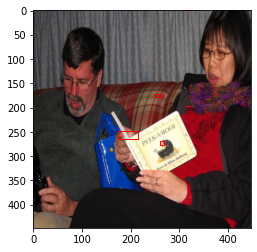

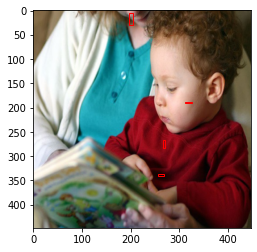

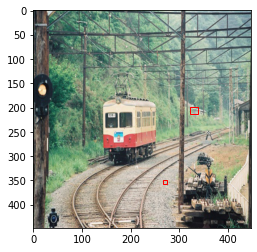

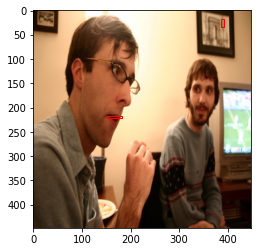

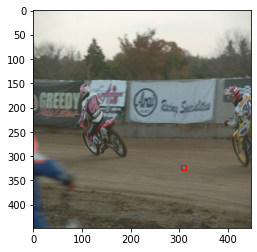

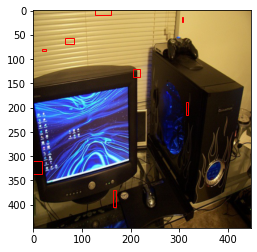

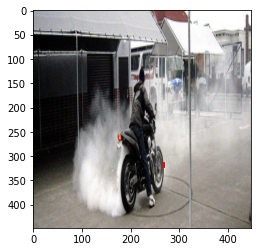

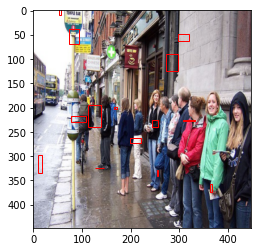

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [84]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolo(size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = Loss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = Dataset(
        "100examples.csv",
        transform=transform,
        img_file=IMG_DIR,
        label_file=LABEL_DIR,
    )

    test_dataset = Dataset(
        "test.csv", transform=transform, img_file=IMG_DIR, label_file=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        for x, y in train_loader:
           x = x.to(DEVICE)
           for idx in range(8):
               bboxes = cellboxes_to_boxes(model(x))
               bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
               plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

           import sys
           sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.9:
           checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
           }
           save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
           import time
           time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

In [64]:

!pwd 

/content/gdrive/My Drive/Kaggle
